# STABLE DIFFUSION
- inspired by Umar Jamil (https://www.youtube.com/watch?v=ZBKpAp_6TGI&t=9309s)

# STABLE DIFFUSION Pt#1: VAE


- Encoder: responsible to encode an image or noise into a compressed version of the image or the noise, s.t., we can take latent and run it through the UNet model. In summary, its job is reduce data into the data with the smaller dimension.
- Decoder: responsible to decode and get the original output image



In [2]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 51.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys


Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/Personal_Projects/Stable_Diffusion/v1-5-pruned-emaonly.ckpt /content
!cp /content/drive/MyDrive/Personal_Projects/Stable_Diffusion/tokenizer_merges.txt /content
!cp /content/drive/MyDrive/Personal_Projects/Stable_Diffusion/tokenizer_vocab.json /content
!cp /content/drive/MyDrive/Personal_Projects/Stable_Diffusion/model_converter.py /content

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms

import model_converter
from torch.utils.data import DataLoader


In [3]:

# transform = transforms.Compose([
#       transforms.ToTensor(),
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#         # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
#     ]
# )

# trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                         download=True, transform=transform)

# # batch_size_train = 128 #256 #64
# # batch_size_test = 100

# trainloader2 = DataLoader(
#     trainset2, batch_size = 16, shuffle=True)
# testloader2 = DataLoader(
#     testset2, batch_size = 16, shuffle=False)
# import matplotlib.pyplot as plt
# import numpy as np

# # functions to show an image

# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # get some random training images
# dataiter =  iter(trainloader)
# images, labels = next(dataiter)
# print(images.size())

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(images.shape[0])))

# Attention
- SelfAttention
- CrossAttention

In [6]:
import math

class SelfAttention(nn.Module):
  def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
    super().__init__()

    self.in_proj = nn.Linear(d_embed, d_embed * 3, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads

  def forward(self, x, causal_mask=False):
    # x: (B, H*W, C)

    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)
    # self.in_proj(x): (B, H*W, C)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)

    # (B, seq_len, d_model) -> (B, num_heads, seq_len, d_head)
    q = q.view(interim_shape).transpose(1,2)
    k = k.view(interim_shape).transpose(1,2)
    v = v.view(interim_shape).transpose(1,2)

    # (B, num_heads, seq_len, seq_len)
    W = q @ k.transpose(-1,-2)

    if causal_mask:
      mask = torch.ones_like(W, dtype=torch.bool).triu(1)
      W.masked_fill_(mask, -torch.inf)

    W /= math.sqrt(self.d_head)
    W = F.softmax(W, dim=-1)

    # (B, num_heads, seq_len, seq_len) @ (B, num_heads, seq_len, d_head)
    # = (B, num_heads, seq_len, d_head)
    out = W @ v
    # (B, num_heads, seq_len, d_head) -> (B, seq_len, num_heads, d_head)
    out = out.transpose(1,2)
    out = out.reshape(input_shape)
    out = self.out_proj(out)

    return out

class CrossAttention(nn.Module):
  def __init__(self, n_heads, d_embed, d_cross, in_proj_bias = True, out_proj_bias=True):
    super().__init__()
    self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads

  def forward(self, x, y):
    # x (latent): (b, h*w, d_model)
    # context: (b, seq_len, embed_dim) = (b, 77, 768)

    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    interim_shape = (batch_size, -1, self.n_heads, self.d_head)

    # (b, seq_len_q, d_model) -> (b, seq_len, d_model)
    q = self.q_proj(x)
    # (b, seq_len_k, dim_k) -> (b, seq_len_k, d_model)
    k = self.k_proj(y)
    # (b, seq_len_v, dim_v) -> (b, seq_len_v, d_model)
    v = self.v_proj(y)

    # divide into heads
    q = q.view(interim_shape).transpose(1,2)
    k = k.view(interim_shape).transpose(1,2)
    v = v.view(interim_shape).transpose(1,2)

    W = q @ k.transpose(-1,-2)
    W /= math.sqrt(self.d_head)
    W = F.softmax(W, dim=-1)

    out = W @ v
    out = out.transpose(1,2).contiguous()
    out = out.view(input_shape)
    out = self.out_proj(out)

    return out

# Variational Autoencoder (VAE) requires
- VAE Attention block
- VAE Residual block

In [7]:
class VAE_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm_1 = nn.GroupNorm(32, in_channels)
    # (B, in_channels, H, W) -> (B, out_channels, H, W)
    self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm_2 = nn.GroupNorm(32, out_channels)
    # (B, out_channels, H, W) -> (B, out_channels, H, W)
    self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      # residual_layer does not affect size of height and width
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x: (B, in_channels, H, W)

    residue = x

    x = self.groupnorm_1(x)
    x = F.silu(x)
    x = self.conv_1(x)

    x = self.groupnorm_2(x)
    x = F.silu(x)
    x = self.conv_2(x)

    # (B, out_channels, H, W)
    return x + self.residual_layer(residue)



class VAE_AttentionBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, channels)
    self.attention = SelfAttention(1,  channels)

  def forward(self, x):
    # x: (B, C, H, W)
    residue = x

    x = self.groupnorm(x)

    b,c,h,w = x.shape

    # (B,C,H,W) -> (B,C, H*W)
    x = x.view((b,c, h*w))
    # (B,C, H*W) -> (B, H*W, C)
    x = x.transpose(-1,-2)
    # self attention
    x = self.attention(x)
    # (B,C, H*W) -> (B,C, H*W)
    x = x.transpose(-1,-2)
    # (B,C, H*W) -> (B,C,H,W)
    x = x.view((b,c,h,w))
    x += residue
    return x


# VAE Encoder

In [8]:
class VAE_Encoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        # (b, 3, h, w) -> (b, 128, h, w)
        nn.Conv2d(3, 128, kernel_size =3, padding = 1),
        VAE_ResidualBlock(128, 128),
        VAE_ResidualBlock(128, 128),

        # (b, 128, h, w) -> (b, 128, h/2, h/2)
        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        # (b, 128, h/2, w/2) -> (b, 256, h/2, h/2)
        VAE_ResidualBlock(128, 256),
        VAE_ResidualBlock(256, 256),
        # (b, 256, h/2, w/2) -> (b, 256, h/4, h/4)
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
        # (b, 256, h/4, w/4) -> (b, 512, h/4, h/4)
        VAE_ResidualBlock(256, 512),
        VAE_ResidualBlock(512, 512),

        # (b, 512, h/4, h/4) -> (b, 512, h/8, h/8)
        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_AttentionBlock(512),
        VAE_ResidualBlock(512, 512),
        nn.GroupNorm(32, 512),
        nn.SiLU(),

        # (b, 512, h/8, h/8) -> (b, 8, h/8, h/8)
        nn.Conv2d(512, 8, kernel_size=3, padding=1),
        nn.Conv2d(8, 8, kernel_size=1, padding=0)
    )

  def forward(self, x, noise):
    # x: (b,c,h,w)
    # noise: (b,4,h//8,w//8)

    for module in self:
      if getattr(module, 'stride', None) == (2,2):
        x = F.pad(x, (0,1,0,1))
      x = module(x)

    # (b, 8, h/8, w/8) -> two tensors of shape (b, 4, h/8, w/8)
    mean, log_variance = torch.chunk(x, 2, dim=1)

    # clamp the log variance to be between -30 and 20
    log_variance = torch.clamp(log_variance, -30, 20)
    variance = log_variance.exp()
    stdev = variance.sqrt()

    # (b, 4, h/8, w/8)
    x = mean + stdev * noise
    x *= 0.18215
    # out: (b, 4, h/8, w/8)
    return x

# test dim
# x = images
# print(x.shape)

# encoder = VAE_Encoder()
# out = encoder.forward(x, torch.randn(x.shape[0], 4, 4, 4))
# print(out.shape)
# torch.Size([16, 3, 32, 32]) -> torch.Size([16, 4, 4, 4])

# VAE Decoder

In [9]:
class VAE_Decoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        # (b, 4, h/8, w/8) -> (b, 4, h/8, w/8)
        nn.Conv2d(4, 4, kernel_size=1, padding=0),
        # (b, 4, h/8, w/8) -> (b, 512, h/8, w/8)
        nn.Conv2d(4, 512, kernel_size=3, padding=1),
        VAE_ResidualBlock(512, 512),
        VAE_AttentionBlock(512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),

        # (b, 512, h/8, w/8) -> (b, 512, h/4, w/4)
        nn.Upsample(scale_factor=2),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),

        # (b, 512, h/4, w/4) -> (b, 512, h/2, w/2)
        nn.Upsample(scale_factor=2),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        # (b, 512, h/2, w/2) -> (b, 256, h/2, w/2)
        VAE_ResidualBlock(512, 256),
        VAE_ResidualBlock(256, 256),
        VAE_ResidualBlock(256, 256),

        # (b, 256, h/2, w/2) -> (b, 256, h, w)
        nn.Upsample(scale_factor=2),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        # (b, 256, h, w) -> (b, 128, h, w)
        VAE_ResidualBlock(256, 128),
        VAE_ResidualBlock(128, 128),
        VAE_ResidualBlock(128, 128),
        nn.GroupNorm(32,128),
        nn.SiLU(),

        # (b, 128, h, w) -> (b, 3, h, w)
        nn.Conv2d(128, 3, kernel_size=3, padding=1)
    )


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x: (b, 4, h/8, w/8)
    # remove the scaling added by the encoder
    x /= 0.18215

    for module in self:
      x = module(x)
    # (b, 4, h/8, w/8) -> (b, in_channels, h, w)
    return x


# # test dim
# x = images
# print(x.shape)

# encoder = VAE_Encoder()
# out = encoder(x, torch.randn(x.shape[0], 4, 4, 4))
# print(out.shape)

# decoder = VAE_Decoder()
# x = decoder(out)
# print(x.shape)
# # torch.Size([16, 3, 32, 32]) -> torch.Size([16, 4, 4, 4])
# # torch.Size([16, 4, 4, 4]) -> torch.Size([16, 3, 32, 32])


# CLIP (Text encoder)

In [10]:
class CLIPEmbedding(nn.Module):
  def __init__(self, n_vocab: int, n_embd: int, n_token: int):
    super().__init__()

    self.token_embedding = nn.Embedding(n_vocab, n_embd)
    # nn.Parameter: learnable matrix encodes position information for each tokens
    self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))

  def forward(self, tokens):
    # x: (b, seq_len) -> (b, seq_len, dim)
    x = self.token_embedding(tokens)
    x += self.position_embedding
    return x

class CLIPLayer(nn.Module):
  def __init__(self, n_head: int, n_embd: int):
    super().__init__()

    self.layernorm_1 = nn.LayerNorm(n_embd)
    self.attention = SelfAttention(n_head, n_embd)

    self.layernorm_2 = nn.LayerNorm(n_embd)
    self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
    self.linear_2 = nn.Linear(4 * n_embd, n_embd)

  def forward(self, x):
    # x: (b, seq_len, embed_dim)
    residue = x

    x = self.layernorm_1(x)
    x = self.attention(x, causal_mask=True)
    x += residue

    residue = x
    x = self.layernorm_2(x)
    x = self.linear_1(x)
    x = x * torch.sigmoid(1.702 * x) # QuickGELU
    x = self.linear_2(x)
    x += residue

    # x: (b, seq_len, embed_dim)
    return x


class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = CLIPEmbedding(49408, 768, 77)
    self.layers = nn.ModuleList([
        CLIPLayer(12, 768) for i in range(12)
    ])
    self.layernorm = nn.LayerNorm(768)

  def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
    tokens = tokens.type(torch.long)

    # (b,seq_len) -> (b, seq_len, dim)
    state = self.embedding(tokens)

    for layer in self.layers:
        # (b, seq_len, dim) -> (b, seq_len, dim)
      state = layer(state)

    out = self.layernorm(state)
    return out

# Stable Diffusion requires
1. Time Embedding
2. CLIP (Text encoder)
3. UNet

## 3. UNet requires
1. Residual block
2. Attention block
3. Switch Sequential
4. Upsample

In [11]:
class TimeEmbedding(nn.Module):
  def __init__(self, n_embd):
    super().__init__()

    self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
    self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x: (1, 320)
    x = self.linear_1(x)
    x = F.silu(x)
    x = self.linear_2(x)

    # x: (1, 320*4) -> (1, 1280)
    return x



In [12]:

class UNET_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_time= 1280):
    super().__init__()

    self.groupnorm_feature = nn.GroupNorm(32, in_channels)
    self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.linear_time = nn.Linear(n_time, out_channels)

    self.groupnorm_merged = nn.GroupNorm(32, out_channels)
    self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, feature, time):
    # x: (b, in_channels, h, w)
    # t: (1, n_time)

    residue = feature

    feature = self.groupnorm_feature(feature)
    feature = F.silu(feature)
    # (b, in_channels, h, w) -> (b, out_channels, h, w)
    feature = self.conv_feature(feature)

    time = F.silu(time)
    # (1, n_time) -> (1, out_channels): (1, 1280) -> (1, out_channels)
    time = self.linear_time(time)

    #(b, out_channels, h, w) + (1, out_channels, 1, 1) = (b, out_channels, h, w)
    merged = feature + time.unsqueeze(-1).unsqueeze(-1)
    merged = self.groupnorm_merged(merged)
    merged = F.silu(merged)
    merged = self.conv_merged(merged)

    #(b, out_channels, h, w)
    return merged + self.residual_layer(residue)


class UNET_AttentionBlock(nn.Module):
  def __init__(self, n_head: int, n_embd: int, d_context=768):
    super().__init__()

    channels = n_head * n_embd

    self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
    self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    self.layernorm_1 = nn.LayerNorm(channels)
    self.attention_1 = SelfAttention(n_head, channels, in_proj_bias = False)

    self.layernorm_2 = nn.LayerNorm(channels)
    self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)

    self.layernorm_3 = nn.LayerNorm(channels)
    self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)
    self.linear_geglu_2 = nn.Linear(4 * channels, channels)

    self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

  def forward(self, x, context):
    # x: (b, c, h, w)
    # context: (b, seq_len, dim)
    residue_long = x

    x = self.groupnorm(x)
    # (b, c, h, w) -> (b, c, h, w)
    x = self.conv_input(x)

    b,c,h,w = x.shape
    x = x.view((b,c, h*w))
    x = x.transpose(-1,-2)

    # (b, h*w, c)
    residue_short = x
    x = self.layernorm_1(x)
    # (b,h*w,c) -> (b, h*w, c)
    x = self.attention_1(x)
    x += residue_short # skip connection

    # (b, h*w, c)
    residue_short = x
    x = self.layernorm_2(x)
    x = self.attention_2(x, context)
    x += residue_short

    residue_short = x
    x = self.layernorm_3(x)
    # (b, h*w, c) -> two tensors of shape (b, h*w, 4*c)
    x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
    x = x * F.gelu(gate)
    # (b, h*w, 4*c) -> (b, h*w, c)
    x = self.linear_geglu_2(x)
    x += residue_short

    x = x.transpose(-1,-2)
    x = x.view((b,c,h,w))

    return self.conv_output(x) + residue_long



In [13]:
class Upsample(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  def forward(self, x):
    # (b,c,h,w) -> (b, c, h*2, w*2)
    x = F.interpolate(x, scale_factor=2, mode='nearest')
    return self.conv(x)

class SwitchSequential(nn.Sequential):
  def forward(self, x, context, time):
    for layer in self:
      if isinstance(layer, UNET_AttentionBlock):
        x = layer(x, context)
      elif isinstance(layer, UNET_ResidualBlock):
        x = layer(x, time)
      else:
        x = layer(x)
    return x


# UNet (A model to predict noise in images)

In [14]:

# UNet_ResidualBlock
# UNet_AttentionBlock
class UNET(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoders = nn.ModuleList([
        # (b, 4, h//8, w//8) -> (b, 320, h//8, w//8)
        SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding =1)),
        #(b, 320, h//8, w//8) -> (b, 320, h//8, w//8)
        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
        #(b, 320, h//8, w//8) -> (b, 320, h//8, w//8)
        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

        # (b, 320, h//8, w//8) -> (b, 320, h//16, w//16)
        SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride= 2, padding =1)),
        # (b, 320, h//16, w//16) -> (b, 640, h//16, w//16)
        SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
        # (b, 320, h//16, w//16) -> (b, 640, h//16, w//16)
        SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),

        # (b, 640, h//16, w//16) -> (b, 640, h//32, w//32)
        SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride= 2, padding =1)),
        # (b, 640, h//32, w//32) -> (b, 1280, h//32, w//32)
        SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
        # (b, 1280, h//32, w//32) -> (b, 1280, h//32, w//32)
        SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

        # (b, 1280, h//32, w//32) -> (b, 1280, h//64, w//64)
        SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride= 2, padding =1)),
        # (b, 1280, h//64, w//64) -> (b, 1280, h//64, w//64)
        SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        # (b, 1280, h//64, w//64) -> (b, 1280, h//64, w//64)
        SwitchSequential(UNET_ResidualBlock(1280, 1280)),

    ])

    self.bottleneck = SwitchSequential(
        UNET_ResidualBlock(1280, 1280),
        UNET_AttentionBlock(8, 160),
        UNET_ResidualBlock(1280, 1280),
    )

    self.decoders = nn.ModuleList([
        # (b, 2560, h//64, w//64) -> (b, 1280, h//64, w//64)
        # Why 2560? because of skip connection from encoder.
        SwitchSequential(UNET_ResidualBlock(2560, 1280)),
        # (b, 2560, h//64, w//64) -> (b, 1280, h//64, w//64)
        SwitchSequential(UNET_ResidualBlock(2560, 1280)),
        # (b, 2560, h//64, w//64) -> (b, 1280, h//32, w//32)
        SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),

        # (b, 2560, h//32, w//32) -> (b, 1280, h//32, w//32)
        SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
        SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
        # (b, 2560, h//64, w//64) -> (b, 1280, h//32, w//32)
        SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),

        SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),

        SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
        SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
    ])

  def forward(self, x, context, time):
    # x: (b, 4, h//8, w//8)
    # context: (b, seq_len, dim)
    # time: (1, 1280)

    skip_connections = []
    for layers in self.encoders:
      x = layers(x, context, time)
      skip_connections.append(x)
    # skip_connection list
    # 1. (b, 320, h//8, w//8)
    # 2. (b, 320, h//8, w//8)
    # 3. (b, 320, h//8, w//8)
    # 4. (b, 320, h//16, w//16)
    # 5. (b, 640, h//16, w//16)
    # 6. (b, 640, h//16, w//16)
    # 7. (b, 640, h//32, w//32)
    # 8. (b, 1280, h//32, w//32)
    # 9. (b, 1280, h//32, w//32)
    # 10.(b, 1280, h//64, w//64)
    # 11.(b, 1280, h//64, w//64)
    # 12.(b, 1280, h//64, w//64)

    x = self.bottleneck(x, context, time)

    for layers in self.decoders:
      x = torch.cat((x, skip_connections.pop()), dim=1)
      x = layers(x, context, time)

    return x

class UNET_OutputLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    # x: (b, 320, h/8, w/8)
    x = self.groupnorm(x)
    x = F.silu(x)
    x = self.conv(x)
    return x



In [15]:

class Diffusion(nn.Module):
  def __init__(self):
    super().__init__()

    self.time_embedding = TimeEmbedding(320)
    self.unet = UNET()
    self.final = UNET_OutputLayer(320, 4)


  def forward(self, latent, context, time):
    # latent: (b, 4, h//8, w//8): encoder(x)
    # context: (b, seq_len, dim)
    # time: (1, 320)

    # (1,320) -> (1,1280)
    time = self.time_embedding(time)
    # (b, 4, h//8, w//8) -> (b, 4, h//8, w//8)
    output = self.unet(latent, context, time)
    # (b, 4, h//8, w//8) -> (b, 4, h//8, w//8)
    output = self.final(output)
    return output


# Diffusion Model (DDPM)

In [16]:
class DDPMSampler:
  def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start: float = 0.00085, beta_end:float = 0.0120):
    self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype=torch.float32) ** 2
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    self.one = torch.tensor(1.0)

    self.generator = generator

    self.num_training_steps = num_training_steps
    self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

  def set_inference_timesteps(self, num_inference_steps=50):
    self.num_inference_steps = num_inference_steps
    # 999, 998, 997, ... 0 : 1000 steps
    # 999, 999-20, 999-40, ... 0 : 1000 / 50 steps

    step_ratio = self.num_training_steps // self.num_inference_steps
    timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
    self.timesteps = torch.from_numpy(timesteps)

  def _get_previous_timestep(self, timestep: int) -> int:
    prev_t = timestep - self.num_training_steps // self.num_inference_steps
    return prev_t

  def _get_variance(self, timestep:int) -> torch.Tensor:
    prev_t = self._get_previous_timestep(timestep)

    alpha_prod_t = self.alphas_cumprod[timestep]
    alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >=0 else self.one
    current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

    # current_beta_t = self.betas[t]
    variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
    variance = torch.clamp(variance, min=1e-20)
    return variance


  def set_strength(self, strength =1):
    start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
    self.timesteps = self.timesteps[start_step:]
    self.start_step = start_step


  def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
    # latents: x_t
    # model_output: unet output (predicted noise)
    t = timestep
    prev_t = self._get_previous_timestep(t)

    # compute alphas, betas
    alpha_prod_t = self.alphas_cumprod[t]
    alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >=0 else self.one

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev

    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # using formula (15) of DDPM paper
    pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

    # compute q(x_{t-1}|x_t, x_0), where x_0: pred_original_sample
    # using formula (6,7) of DDPM paper
    pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

    # Add noise
    variance = 0
    if t > 0:
      device = model_output.device
      noise = torch.randn(model_output.shape, generator = self.generator, device = device, dtype = model_output.dtype)
      variance = (self._get_variance(t) ** 0.5) * noise

    # N(0, 1) -> N(mu, sigma^2)
    # X = mu + sigma * Z, where Z ~ N(0,1)
    pred_prev_sample = pred_prev_sample + variance
    return pred_prev_sample


  def add_noise(self, original_samples: torch.FloatTensor, timesteps: torch.IntTensor) -> torch.FloatTensor:
    alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype= original_samples.dtype)
    timesteps = timesteps.to(original_samples.device)

    sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()

    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
      sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

    sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
      sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    noise = torch.randn(original_samples.shape, generator = self.generator, device=original_samples.device, dtype = original_samples.dtype)
    noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
    return noisy_samples






# PIPELINE

In [17]:
def rescale(x, old_range, new_range, clamp=False):
  old_min, old_max = old_range
  new_min, new_max = new_range

  x -= old_min
  x *= (new_max - new_min) / (old_max - old_min)
  x += new_min

  if clamp:
    x = x.clamp(new_min, new_max)
  return x

def get_time_embedding(timestep):
  # (160, )
  freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
  # (1, 160)
  x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
  return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)


In [18]:
import torch
import numpy as np
from tqdm import tqdm



# allowing text to image or image to image
def generate(prompt,
             uncond_prompt= None, # Negative prompt or empty string
             input_image = None,
             strength = 0.8,
             do_cfg = True,
             cfg_scale=7.5,
             sampler_name = "ddpm",
             n_inference_steps = 50,
             models = {},
             seed = None,
             device=None,
             idle_device=None,
             tokenizer=None
             ):

  width = 512
  height = 512
  # after encoding through VAE
  latents_width = width // 8
  latents_height = height // 8


  with torch.no_grad():
    if not 0 < strength <= 1:
      raise ValueError("strength must be between 0 and 1")

    if idle_device:
      to_idle = lambda x: x.to(idle_device)
    else:
      to_idle = lambda x: x

    generator = torch.Generator(device=device)
    if seed is None:
      generate.seed()
    else:
      generator.manual_seed(seed)

    clip = models["clip"]
    clip.to(device)

    #cfg: Classifier Free Guidance (combine output)
    #output = w * (output_conditioned - output_unconditioned) + output_unconditioned
    #w: A weight that indicates how much we want the model to pay attention to the conditioning signal (prompt)

    if do_cfg:
      # convert the prompt into tokens using the tokenizer
      # sequence length is 77
      cond_tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      # (b, seq_len)
      cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
      # (b, seq_len) -> (b, seq_len, dim) = (b, 77, 768)
      cond_context = clip(cond_tokens)

      uncond_tokens = tokenizer.batch_encode_plus([uncond_prompt], padding="max_length", max_length=77).input_ids
      uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
      uncond_context = clip(uncond_tokens)

      # (2, seq_len, 768) = (2, 77, 768)
      context = torch.cat([cond_context, uncond_context])
    else:
      # convert it into a list of tokens
      tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      tokens = torch.tensor(tokens, dtype=torch.long, device=device)
      #(1, 77, 768)
      context = clip(tokens)
    to_idle(clip)

    if sampler_name == "ddpm":
      sampler = DDPMSampler(generator)
      sampler.set_inference_timesteps(n_inference_steps)
    else:
      raise ValueError(f"Unknown sampler {sampler_name}")

    latent_shape = (1, 4, latents_height, latents_width)

    if input_image:
      encoder = models["encoder"]
      encoder.to(device)


      input_image_tensor = input_image.resize((height, width))
      input_image_tensor = np.array(input_image_tensor)
      input_image_tensor = torch.tensor(input_image_tensor, dtype= torch.float32, device = device)

      # UNet wants every channel every pixel to be between -1 and 1
      input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
      # (h, w, c) -> (b, h, w, c)
      input_image_tensor = input_image_tensor.unsqueeze(0)
      # (h, w, c) -> (b, c, h, w)
      input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)

      encoder_noise = torch.randn(latent_shape, generator= generator, device=device)

      # run the image through the VAE encoder
      latents = encoder(input_image_tensor, encoder_noise)

      sampler.set_strength(strength=strength)
      latents = sampler.add_noise(latents, sampler.timesteps[0])

      to_idle(encoder)
    else:
      latents = torch.randn(latent_shape, generator= generator, device=device)

    # DDPM
    diffusion = models["diffusion"]
    diffusion.to(device)

    timesteps = tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
      # (1, 320)
      time_embedding = get_time_embedding(timestep).to(device)

      # (b, 4, latents_height, latents_width)
      model_input = latents

      if do_cfg:
        # (b, 4, latents_height, latents_width) -> (2*b, 4, latents_height, latents_width)
        model_input = model_input.repeat(2, 1, 1, 1)

      # model output: predicted noise by the UNet
      model_output = diffusion(model_input, context, time_embedding)

      if do_cfg:
        output_cond, output_uncond = model_output.chunk(2)
        model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

      # remove predicted noise by the UNet
      latents = sampler.step(timestep, latents, model_output)

    to_idle(diffusion)

    decoder = models["decoder"]
    decoder.to(device)

    images = decoder(latents)
    to_idle(decoder)

    images = rescale(images, (-1, 1), (0, 255), clamp=True)
    # (b, c, h, w) -> (b, h, w, c)
    images = images.permute(0, 2, 3, 1)
    images = images.to("cpu", torch.uint8).numpy()
    return images[0]








# Load model

In [19]:

def preload_models_from_standard_weights(ckpt_path, device):
  state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

  encoder = VAE_Encoder().to(device)
  encoder.load_state_dict(state_dict['encoder'], strict=True)

  decoder = VAE_Decoder().to(device)
  decoder.load_state_dict(state_dict['decoder'], strict=True)

  diffusion = Diffusion().to(device)
  diffusion.load_state_dict(state_dict['diffusion'], strict=True)

  clip = CLIP().to(device)
  clip.load_state_dict(state_dict['clip'], strict=True)

  return {
    'clip': clip,
    'encoder': encoder,
    'decoder': decoder,
    'diffusion': diffusion,
  }

# encoder = VAE_Encoder().to(device)
#state_dict()


In [20]:
from transformers import CLIPTokenizer
from PIL import Image
from pathlib import Path


device = "cpu"
allow_cuda = True
allow_mps = False

if torch.cuda.is_available() and allow_cuda:
  device = "cuda"
elif torch.backends.mps.is_available() and allow_mps:
  device = "mps"
print(f"using device {device}")

tokenizer = CLIPTokenizer("/content/tokenizer_vocab.json", merges_file = "/content/tokenizer_merges.txt")
model_file = "/content/v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file, device)



using device cuda


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


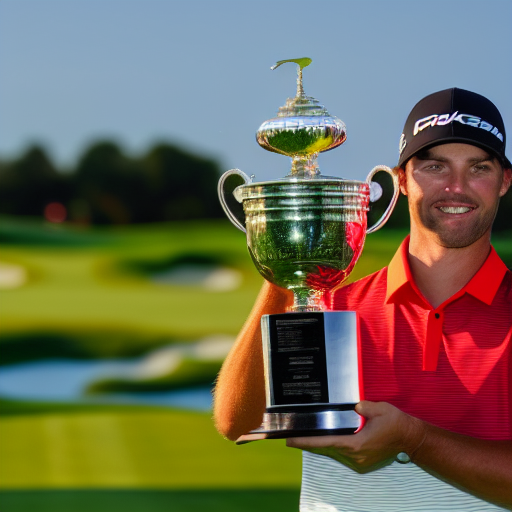

In [26]:

# txt to img
#prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A golf player holding a trophy after winning a pga tour, highly detailed, 8k resolution"
uncond_prompt = "" # You can use it as a negative prompt
do_cfg = True
cfg_scale = 8

# img to img
input_img = None
img_path = "/content/drive/MyDrive/Personal_Projects/Stable_Diffusion/images/dog.png"
# input_img = Image.open(img_path)
strength = 0.9

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_img = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image = input_img,
    strength = strength,
    do_cfg = do_cfg,
    cfg_scale=cfg_scale,
    sampler_name = sampler,
    n_inference_steps = num_inference_steps,
    models = models,
    seed = seed,
    device=device,
    idle_device="cpu",
    tokenizer=tokenizer
)

Image.fromarray(output_img)
